# 1141ML Final - DSM 2D - Blob and Line

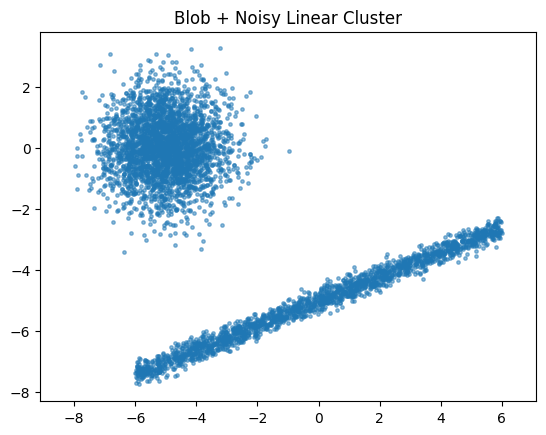

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cpu")

sigma_dsm=1.2
batch_size=2048

#=========== Sample
def sample_noisy_line(n_points):
    slope = 0.4
    intercept = -5.0
    
    x = np.random.uniform(-6, 6, size=n_points)
    noise = np.random.randn(n_points) * 0.2   
    y = slope * x + intercept + noise

    return np.stack([x, y], axis=1)

def sample_blob(n_points):
    mu = np.array([-5, 0])
    C = np.eye(2) * 1.0
    return mu + np.random.multivariate_normal([0,0], C, size=n_points)

def sample_p0_mix(n_blob=3000, n_line=2000):
    blob = sample_blob(n_blob)
    line = sample_noisy_line(n_line)

    data = np.concatenate([blob, line], axis=0)
    np.random.shuffle(data)
    return data

#=============== Plot sample
data = sample_p0_mix()

plt.scatter(data[:,0], data[:,1], s=6, alpha=0.5)
plt.axis('equal')
plt.title("Blob + Noisy Linear Cluster")
plt.show()


In [ ]:
def sample_noisy_x_2d(batch_size, sigma):
    data = sample_p0_mix(n_blob=batch_size//2, n_line=batch_size//2)
    x = data.astype(np.float32)

    eps = np.random.randn(batch_size, 2).astype(np.float32)
    x_tilde = x + sigma * eps
    return x_tilde, eps


In [ ]:
class ScoreNet(nn.Module):
    def __init__(self, x_dim, hidden, num_layers):
        super().__init__()

        layers = [nn.Linear(x_dim, hidden), nn.SiLU()]
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden, hidden))
            layers.append(nn.SiLU())
        layers.append(nn.Linear(hidden, x_dim))  # output same dimension

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model = ScoreNet(x_dim=2, hidden=128, num_layers=4).to(device)

def dsm_loss_step_2d():
    x_tilde_np, eps_np = sample_noisy_x_2d(batch_size, sigma_dsm)

    x_tilde = torch.from_numpy(x_tilde_np).to(device)
    eps     = torch.from_numpy(eps_np).to(device)

    s_hat = model(x_tilde)

    target = -eps / sigma_dsm

    loss = ((s_hat - target)**2).mean()
    return loss


In [ ]:
#### Training Loop
num_steps=5000
lr=5e-4

optimizer=optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,       
    patience=200,   
    verbose=True
)
loss_history = []

for step in range(1, num_steps+1):
    model.train()

    loss = dsm_loss_step_2d()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    scheduler.step(loss)

    loss_history.append(loss.item())

    if step % 200 == 0:
        print(f"step {step:4d} | loss = {loss.item():.6f} | lr = {lr:.6f}")


c:\Users\user\.conda\envs\ml_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


step  200 | loss = 0.331429 | lr = 0.000500
step  400 | loss = 0.329237 | lr = 0.000500
step  600 | loss = 0.321116 | lr = 0.000500
step  800 | loss = 0.332954 | lr = 0.000500
step 1000 | loss = 0.320624 | lr = 0.000500
step 1200 | loss = 0.328799 | lr = 0.000500
step 1400 | loss = 0.314757 | lr = 0.000500
step 1600 | loss = 0.320104 | lr = 0.000500
step 1800 | loss = 0.333376 | lr = 0.000500
step 2000 | loss = 0.308556 | lr = 0.000500
step 2200 | loss = 0.323439 | lr = 0.000500
step 2400 | loss = 0.334217 | lr = 0.000500
step 2600 | loss = 0.315247 | lr = 0.000500
step 2800 | loss = 0.335370 | lr = 0.000500
step 3000 | loss = 0.317237 | lr = 0.000500
step 3200 | loss = 0.324514 | lr = 0.000500
step 3400 | loss = 0.314588 | lr = 0.000500
step 3600 | loss = 0.324848 | lr = 0.000500
step 3800 | loss = 0.324542 | lr = 0.000500
step 4000 | loss = 0.313232 | lr = 0.000500
step 4200 | loss = 0.331297 | lr = 0.000500
step 4400 | loss = 0.324960 | lr = 0.000500
step 4600 | loss = 0.322594 | lr

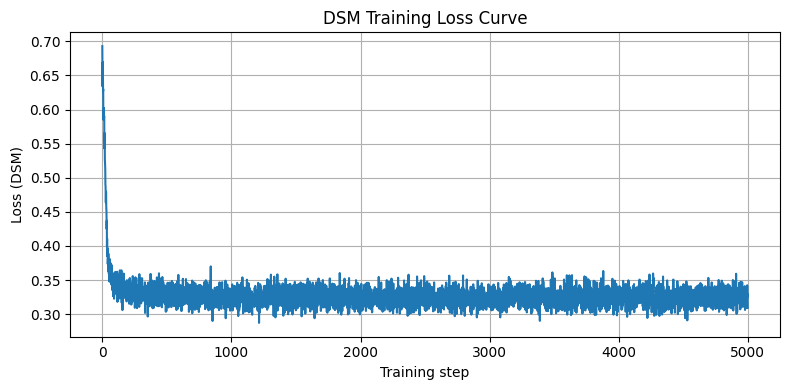

In [ ]:
def plot_loss_curve(loss_list):
    """
    loss_list: Python list or Tensor containing loss values for each step
    """
    plt.figure(figsize=(8,4))
    plt.plot(loss_list, linewidth=1.5)
    plt.xlabel("Training step")
    plt.ylabel("Loss (DSM)")
    plt.title("DSM Training Loss Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_loss_curve(loss_history)

## 2D Langevin sampling - blob and line

In [ ]:
def langevin_sampling_2d(model, steps=6000, eta=0.002, N=5000):
    model.eval()
    x = torch.randn(N, 2).to(device)   

    sqrt_2eta = torch.sqrt(torch.tensor(2*eta, device=device))

    with torch.no_grad():
        for k in range(steps):
            score = model(x)
            noise = torch.randn_like(x)
            x = x + eta * score + sqrt_2eta * noise

    return x.cpu().numpy()

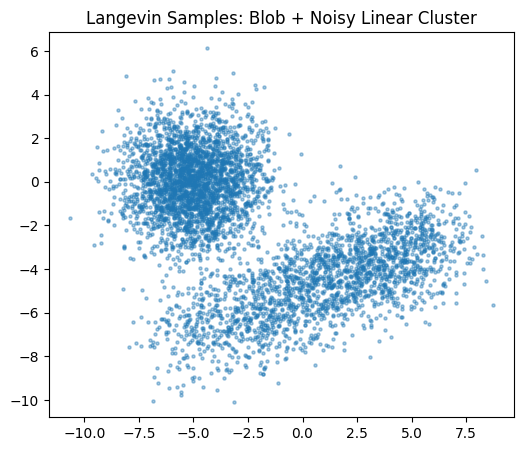

In [ ]:
samples = langevin_sampling_2d(model, steps=6000, eta=0.002, N=5000)

plt.figure(figsize=(6,5))
plt.scatter(samples[:,0], samples[:,1], s=5, alpha=0.4)
plt.axis("equal")
plt.title("Langevin Samples: Blob + Noisy Linear Cluster")
plt.show()


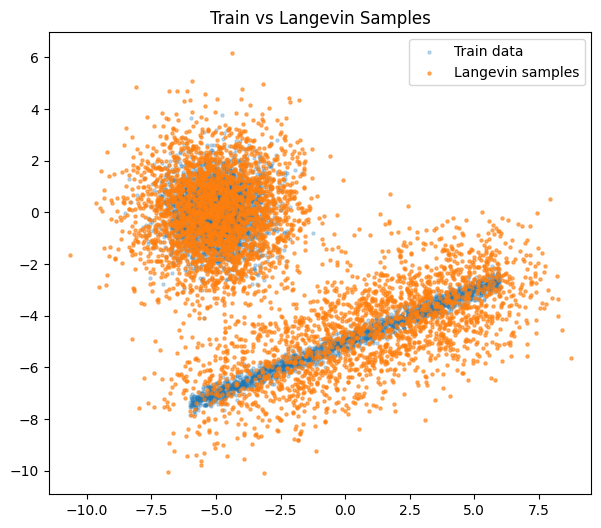

In [ ]:
data = sample_p0_mix(n_blob=3000, n_line=2000)  # 你前面定義的那個

plt.figure(figsize=(7,6))
plt.scatter(data[:,0],    data[:,1],    s=5, alpha=0.25, label="Train data")
plt.scatter(samples[:,0], samples[:,1], s=5, alpha=0.6,  label="Langevin samples")
plt.axis("equal")
plt.legend()
plt.title("Train vs Langevin Samples")
plt.show()


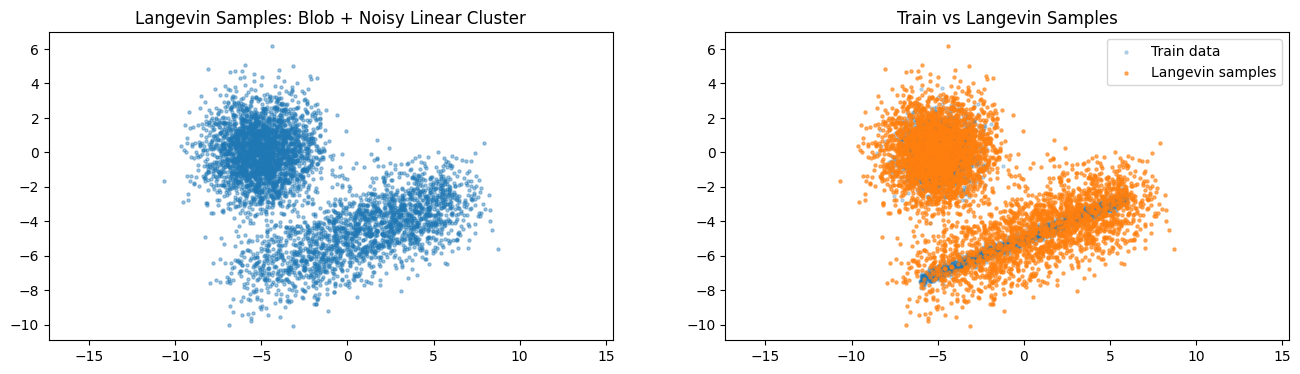

In [31]:
plt.figure(figsize=(16,4))


plt.subplot(1,2,1)
plt.scatter(samples[:,0], samples[:,1], s=5, alpha=0.4)
plt.title("Langevin Samples: Blob + Noisy Linear Cluster")
plt.axis("equal")

plt.subplot(1,2,2)
plt.scatter(data[:,0],    data[:,1],    s=5, alpha=0.25, label="Train data")
plt.scatter(samples[:,0], samples[:,1], s=5, alpha=0.6,  label="Langevin samples")
plt.legend()
plt.title("Train vs Langevin Samples")
plt.axis("equal")

plt.show()


## p0->pT->p0'

In [14]:
def sample_p0(n=5000):
    # blob
    blob = np.random.randn(n//2, 2) @ np.array([[1.0, 0.3],[0.3,1.0]]) + np.array([-5, 0])

    # line
    x = np.random.uniform(-2, 6, size=(n//2, 1))
    y = 0.8 * x + np.random.randn(n//2, 1)*0.5 - 6
    line = np.concatenate([x, y], axis=1)

    return np.vstack([blob, line]).astype(np.float32)


In [15]:
def add_noise(x0, sigma_T):
    eps = np.random.randn(*x0.shape).astype(np.float32)
    return x0 + sigma_T * eps


In [26]:
def langevin_denoise(model, xT, steps=1000, eta=0.02):
    x = torch.tensor(xT, device=device)

    for k in range(steps):
        #print("Steps: ", k)
        with torch.no_grad():
            score = model(x)
            noise  = torch.randn_like(x)
            x = x + eta * score + torch.sqrt(torch.tensor(2*eta)) * noise

    return x.cpu().numpy()


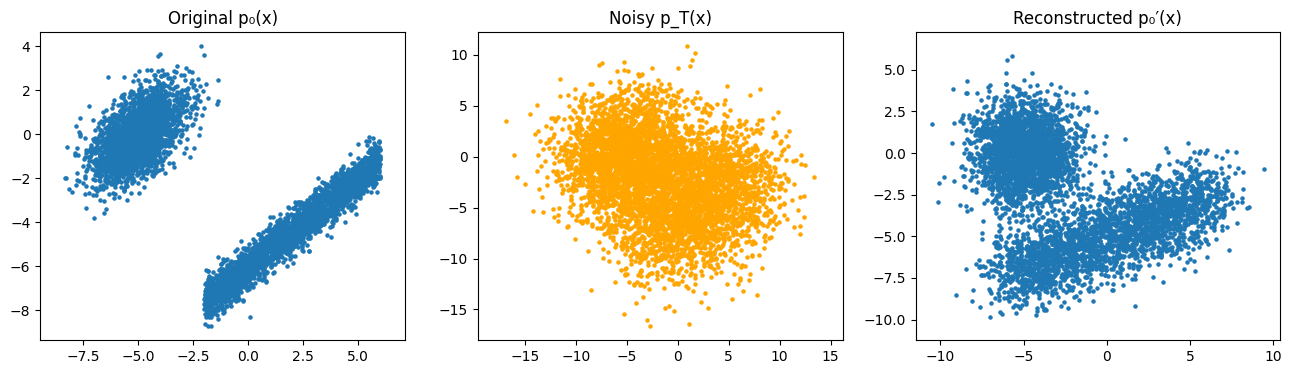

In [27]:
import matplotlib.pyplot as plt

x0 = sample_p0(5000)
xT = add_noise(x0, sigma_T=3.0)
x0p = langevin_denoise(model, xT, steps=2000, eta=0.02)

plt.figure(figsize=(16,4))


plt.subplot(1,3,1)
plt.scatter(x0[:,0], x0[:,1], s=5)
plt.title("Original p₀(x)")
plt.axis("equal")

plt.subplot(1,3,2)
plt.scatter(xT[:,0], xT[:,1], s=5, color="orange")
plt.title("Noisy p_T(x)")
plt.axis("equal")

plt.subplot(1,3,3)
plt.scatter(x0p[:,0], x0p[:,1], s=5)
plt.title("Reconstructed p₀′(x)")
plt.axis("equal")

plt.show()


In [ ]:
def summary_stats(x, name="distribution"):
    x = np.array(x)
    mean = x.mean(axis=0)
    var = x.var(axis=0)
    cov = np.cov(x.T)

    print(f"Summary of {name}:")
    print(f"  Mean      = {mean}")
    print(f"  Variance  = {var}")
    print(f"  Covariance matrix:\n{cov}")
    print("========")

summary_stats(x0, "Original p₀(x)")
summary_stats(xT, "Noisy p_T(x)")
summary_stats(x0p, "Reconstructed p₀′(x)")


Summary of Original p₀(x):
  Mean      = [-1.527338  -2.2257447]
  Variance  = [15.288659   7.3772345]
  Covariance matrix:
[[15.29172078 -5.2124597 ]
 [-5.2124597   7.37870613]]
Summary of Noisy p_T(x):
  Mean      = [-1.5389336 -2.1877134]
  Variance  = [24.621391 16.50206 ]
  Covariance matrix:
[[24.62631444 -5.4697235 ]
 [-5.4697235  16.50534585]]
Summary of Reconstructed p₀′(x):
  Mean      = [-2.2369108 -2.5721664]
  Variance  = [15.0849905  9.020428 ]
  Covariance matrix:
[[15.08800065 -3.85494417]
 [-3.85494417  9.02223302]]
